## Brandmeldingen Amsterdam 2012-2015 

http://data.amsterdam.nl/dataset/brandmeldingen-2010-2015

Overzicht van alle meldingen van de Brandweer Amsterdam-Amstelland in de periode van 2010 tot 2015 (deels). Van alle meer dan 125.000 meldingen is het type melding, locatie (op buurtniveau), datum/tijd en prioriteit beschikbaar.

In [2]:
# load in modules
%matplotlib inline
import os; import csv
import pandas as pd ; import numpy as np
import matplotlib.pyplot as plt; import seaborn as sns
from collections import defaultdict, Counter
import shapefile # pip install pyshp

In [3]:
# settings matplotlib and paths
pd.set_option('display.max_columns', 100)
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 10.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [15., 6.]
path = 'C:\\Users\\Schiphol\\Documents\\data\\'
file = 'brwaa_2010-2015.csv'

In [4]:
# clean and read-in function
def read_file(fp, sep):
    df = (pd.read_csv(fp, sep = ';')
          .pipe(strip_cols)
          .assign(datum = lambda x: pd.to_datetime(x['datum'], format= '%Y-%m-%d'),
                  start_tijd = lambda x: pd.to_datetime(x['start_tijd'], format= '%Y-%m-%d %H:%M:%S'),
                  index = lambda x:  1)
          .rename(columns={'landelijke_meldingsclassificatie_niveau1': 'melding_1',
                           'landelijke_meldingsclassificatie_niveau2': 'melding_2',
                           'landelijke_meldingsclassificatie_niveau3': 'melding_3'})
         )
    return df
        
def strip_cols(df):
    cols_to_clean = ['incident_type', 'maand_naam', 'dag_naam', 'dagdeel', 'landelijke_meldingsclassificatie_niveau3',
                    'landelijke_meldingsclassificatie_niveau2','landelijke_meldingsclassificatie_niveau1','objecttype', 
                     'objectfunctie', 'buurt', 'wijk', 'woonplaats', 'gemeente']
    df.loc[: , (cols_to_clean)] = df.loc[: , (cols_to_clean)].apply(lambda x: x.str.strip().replace('', np.nan).fillna('Onbekend'))
    df = df.copy()
    return df

In [5]:
# read in data and store in df
df = read_file(path + file, sep = ';')
df['jaar'] = df['datum'].dt.year

In [7]:
df.head(2)

,incident_id,start_tijd,incident_type,melding_1,melding_2,melding_3,datum,jaar,maand_nr,maand_naam,dag_nr,dag_naam,week_nr,kwartaal,prioriteit,uur,dagdeel,objecttype,objectfunctie,buurt,wijk,woonplaats,gemeente,index
0,84149,2009-12-07 20:01:50,Meten / overlast / verontreiniging,Dienstverlening,Burger Dienst,Stankoverlast Burger,2009-12-07,2009,12,December,7,Dinsdag,50,4,2,20,Avond,bag,Woonfunctie,Kinkerbuurt,Stadsdeel West,Amsterdam,Amsterdam,1
1,45831,2012-10-13 22:05:10,Buitenbrand,Brand,Wegvervoer,Onbekend,2012-10-13,2012,10,Oktober,13,Zondag,41,4,1,22,Avond,weg,Straat,Buikslotermeer,Stadsdeel Noord,Onbekend,Amsterdam,1


In [8]:
# top 5 incident types
df.incident_type.value_counts()[:5]

OMS / automatische melding    20908
Buitenbrand                   17611
Liftopsluiting                 9950
Hulpverlening algemeen         9943
Assistentie Ambulance          9233
Name: incident_type, dtype: int64

Most common incidents are OMS / automatische melding, buitenbrand en liftopsluiting. Note sure what this first incident type is exactly, so let's first see in which top 10 neighborhoods the second and third types are occuring the most:

In [9]:
top_n = 10
for incidents in ['Buitenbrand' ,'Liftopsluiting']:
    incident_counts = df.query("incident_type == @incidents & buurt != 'Onbekend'")['buurt'].value_counts()
    print ("\nTop {} {} neighborhoods: \n{}".format(top_n, incidents, incident_counts[:top_n]))


Top 10 Buitenbrand neighborhoods: 
Sloten- en Riekerpolder                484
Volewijck                              451
Slotermeer-Zuidwest                    414
Bijlmer-Centrum (D, F, H)              394
Middelveldsche Akerpolder en Sloten    360
Landlust                               313
Overtoomse Veld                        310
Geuzenveld                             296
Bijlmer-Oost (E, G, K)                 294
Slotervaart                            294
Name: buurt, dtype: int64

Top 10 Liftopsluiting neighborhoods: 
Bijlmer-Oost (E, G, K)       1396
Bijlmer-Centrum (D, F, H)    1197
Buikslotermeer                398
Overtoomse Veld               227
Groenelaan                    225
Oostelijk Havengebied         219
Buitenveldert-West            215
Osdorp-Midden                 206
Osdorp-Oost                   187
Burgwallen-Nieuwe Zijde       169
Name: buurt, dtype: int64


In [11]:
# let's pick an incident like 'Assistentie Ambulance' and see where and when these occured most:
ambulance = df.query("incident_type == 'Assistentie Ambulance' & wijk != 'Onbekend'")

# contigency table
tab = pd.crosstab(ambulance['wijk'], ambulance['uur']).fillna(0)

# sort
tab = tab.loc[tab.sum(1).sort_values(ascending= False).index][:20]

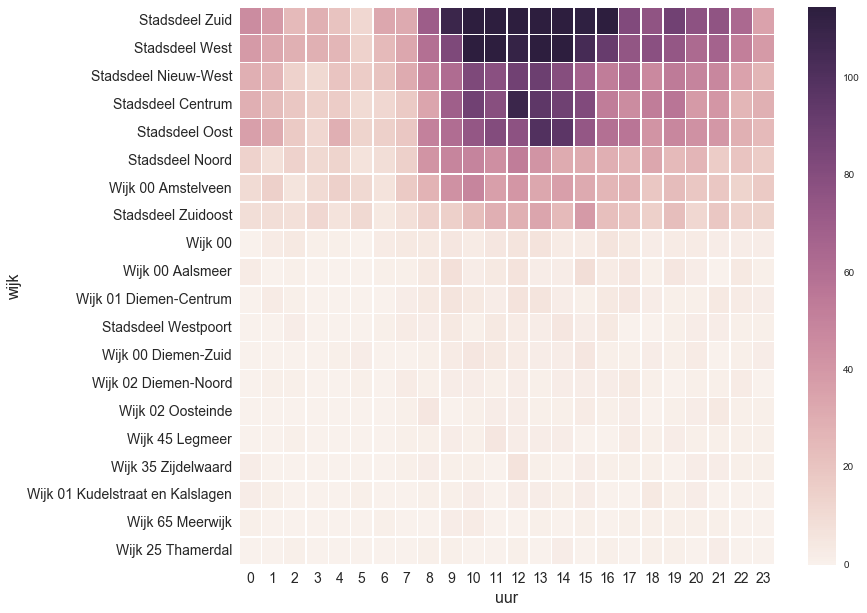

In [13]:
#### TO DO: colors mapped to row values
ax = sns.heatmap(tab, linewidths=.5 ,robust=True ,annot_kws = {'size':14})
ax.tick_params(labelsize=14)
ax.figure.set_size_inches((12, 10))  # update the plot size

### analysis

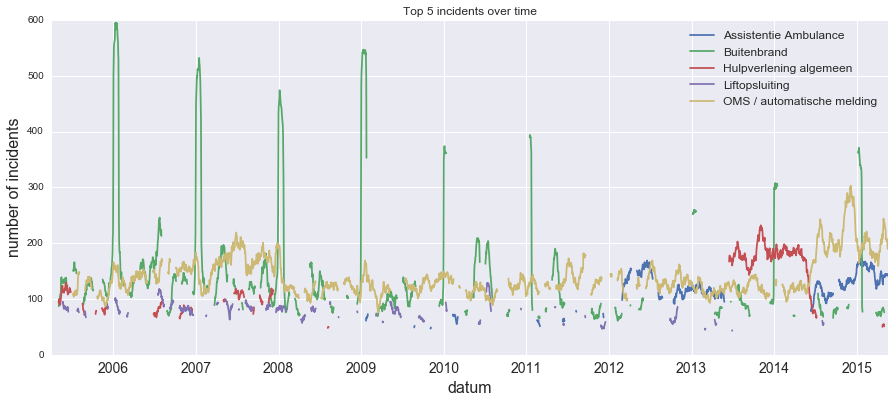

In [14]:
## plot top 5 incidents over time. 
p = (df.query("incident_type != 'Onbekend'").loc[df['incident_type'].isin(df['incident_type'].value_counts().index[:5])]
   .set_index('datum')
   # TimeGrouper to resample & groupby at once
   .groupby(['incident_type', pd.TimeGrouper("H")])
   .buurt.count()
   .unstack(0)
   .rolling(24)
   .sum()
   .rename_axis("top 5 incidents", axis=1)
   .plot()
)
_ = p.set(xlabel = 'datum', ylabel ='number of incidents', title = 'Top 5 incidents over time'), p.legend(fontsize = 12.)

We can clearly see how buitenbranden (fires) are spiking at New Year's

In [15]:
(df.query("wijk != 'Onbekend'").groupby(['wijk', 'melding_1'])['melding_1'].count().unstack(level=1)
.fillna(0))

melding_1,Alarm,Bezitsaantasting,Brand,Dienstverlening,Gezondheid,Leefmilieu,Ongeval,Overige,Railvervoer,Veiligheid en openbare orde,Verkeer
wijk,,,,,,,,,,,
Stadsdeel Centrum,1087.0,3.0,4882.0,5646.0,2182.0,450.0,260.0,23.0,19.0,54.0,67.0
Stadsdeel Nieuw-West,661.0,0.0,5841.0,5708.0,2606.0,302.0,173.0,8.0,9.0,53.0,209.0
Stadsdeel Noord,390.0,2.0,4413.0,4389.0,1459.0,246.0,160.0,17.0,0.0,45.0,153.0
Stadsdeel Oost,1232.0,5.0,5677.0,4707.0,1987.0,293.0,166.0,19.0,17.0,47.0,165.0
Stadsdeel West,425.0,1.0,4637.0,6257.0,3032.0,409.0,106.0,3.0,9.0,58.0,111.0
Stadsdeel Westpoort,365.0,2.0,1305.0,555.0,104.0,37.0,71.0,4.0,11.0,1.0,94.0
Stadsdeel Zuid,937.0,0.0,5206.0,6464.0,3391.0,487.0,146.0,6.0,19.0,85.0,96.0
Stadsdeel Zuidoost,675.0,0.0,3610.0,5609.0,1048.0,197.0,93.0,6.0,7.0,28.0,95.0
Wijk 00,58.0,0.0,682.0,541.0,172.0,40.0,60.0,2.0,4.0,2.0,96.0


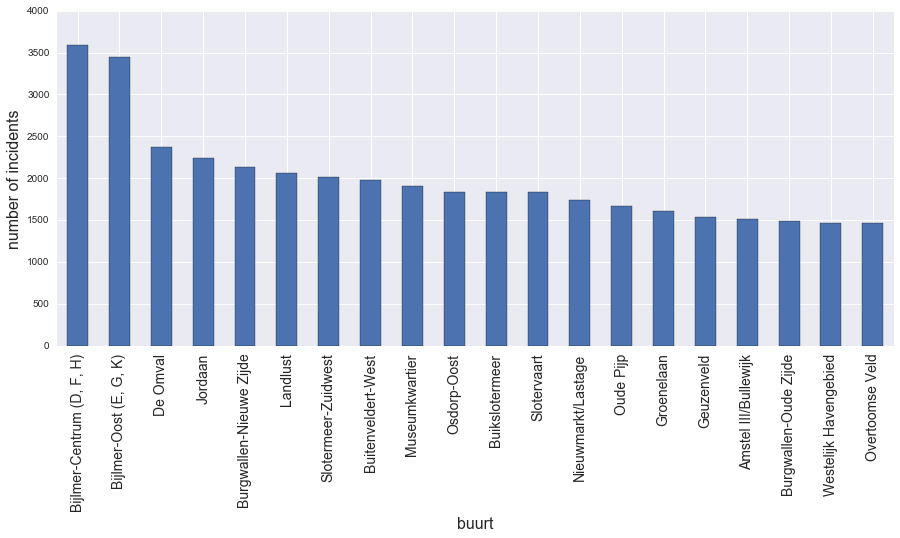

In [16]:
# summed indicents per wijk (neighborhood)
p = df.query("buurt != 'Onbekend'").buurt.value_counts()[:20].plot.bar(rot=90)
_ = p.set(xlabel = 'buurt', ylabel = 'number of incidents')

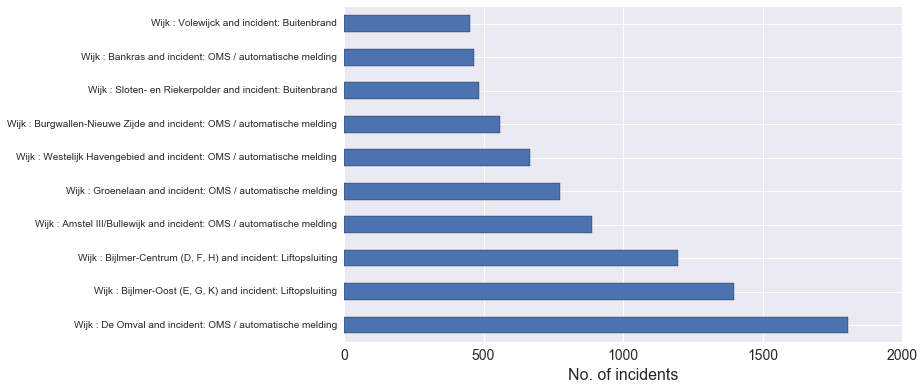

In [17]:
# most common incident per wijk sorted
c = sorted(list(Counter([tuple(x) for x in df.query("buurt != 'Onbekend'")\
                         .dropna(subset = ["buurt", "incident_type"])
                  [["buurt", "incident_type"]].values]).items()), key = lambda x: x[1], reverse= True)
p = pd.DataFrame(c)[:10].plot.barh(figsize = (10, 6))
_ = p.set(yticklabels = ["Wijk : %s and incident: %s" % (x[0], x[1]) for x in list(zip(*c))[0]]
           , xlabel = "No. of incidents"), p.legend("")

Not sure what 'automatische melding' could mean but it's surely happening a lot in the Omval. Liftopsluitingen (person stuck in an elevator) occur a lot in the Bijlmer

In [18]:
# create tuples out of unique wijk/ buurt collections using defaultdict
wijk_buurt_list = list(zip(df['wijk'], df['buurt']))
buurt_wijk = defaultdict(set)
for wijk, buurt in wijk_buurt_list:
    if buurt != 'Onbekend':
        buurt_wijk[wijk].add(buurt) # use add with defaultdict(set), append with lists

In [19]:
# this wijk-buurt dict is handy 
buurt_wijk

defaultdict(set,
            {'Stadsdeel Centrum': {'Burgwallen-Nieuwe Zijde',
              'Burgwallen-Oude Zijde',
              'De Weteringschans',
              'Grachtengordel-West',
              'Grachtengordel-Zuid',
              'Haarlemmerbuurt',
              'Jordaan',
              'Nieuwmarkt/Lastage',
              'Oostelijke Eilanden/Kadijken',
              'Weesperbuurt/Plantage'},
             'Stadsdeel Nieuw-West': {'De Punt',
              'Eendracht',
              'Geuzenveld',
              'Lutkemeer en Ookmeer',
              'Middelveldsche Akerpolder en Sloten',
              'Osdorp-Midden',
              'Osdorp-Oost',
              'Overtoomse Veld',
              'Sloten- en Riekerpolder',
              'Slotermeer-Noordoost',
              'Slotermeer-Zuidwest',
              'Slotervaart',
              'Spieringhorn',
              'Westlandgracht'},
             'Stadsdeel Noord': {'Banne Buiksloot',
              'Buiksloterham',
              

## time to get a high-over view on what incidents occur a lot in which neigborhood

Clustermaps are great for this and the Seaborn has one that isn't hard to construct. Clustermaps are hierarchically clustered heatmaps of a dataframe

In [20]:
# first get the rightly formatted data in for the clustermap
def incident_wijk(df,per):
    
    # Group by incident_type and wijk 
    t =(df.groupby('incident_type').wijk.value_counts(sort=True).unstack().fillna(0))
           
    # Sort by wijk_sum
    wijk_sum = t.sum(axis=0).sort_values(ascending=False)
    t=t[wijk_sum.index]
    
    # Filter by incident_sum per wijk
    incident_sum=t.sum(axis=1).sort_values()    
    
    # slice data.
    p=np.percentile(incident_sum,per)
    ix=incident_sum[incident_sum>p]
    t=t.loc[ix.index]
    return t
    
t=incident_wijk(df,25)

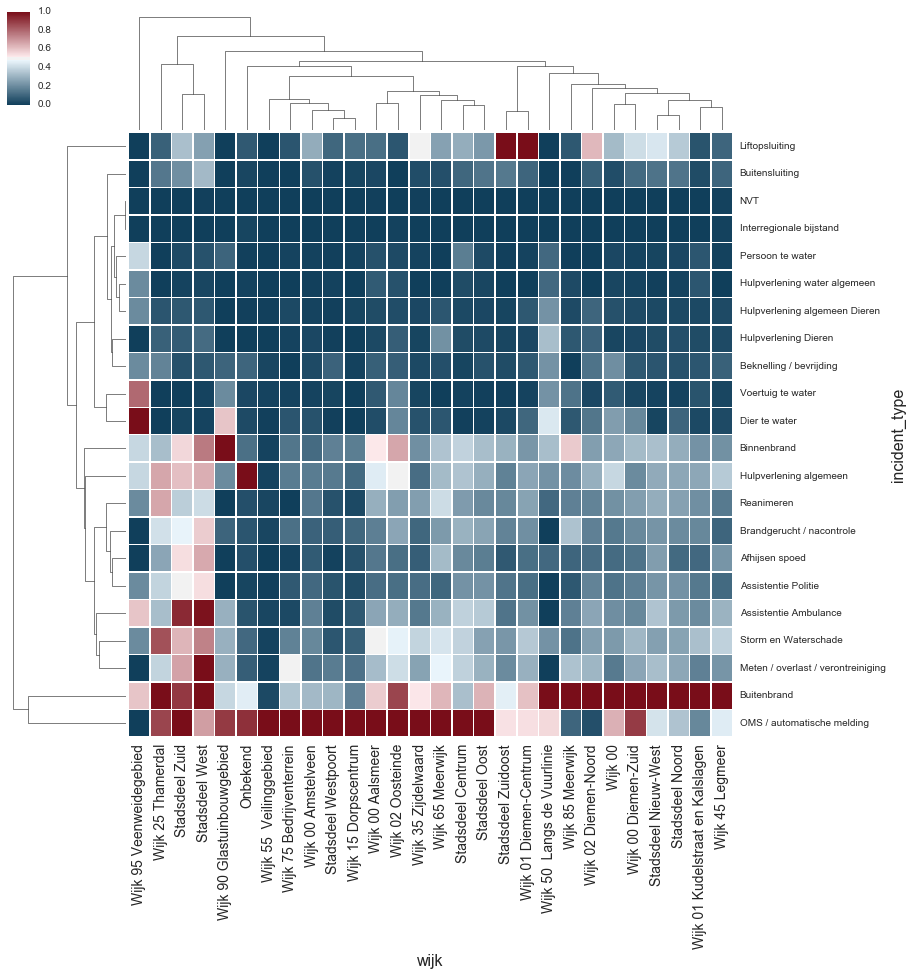

In [21]:
# construct a nice colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=10, s=90, l=25, as_cmap=True) 
# Distance metric to use for the data is euclidean 
cg = sns.clustermap(t, metric="euclidean", standard_scale=1, 
                    linewidths=.5, figsize=(13, 13), cmap=cmap)
# Normalize vertically across wijk.
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

The height of the dendogram branches indicate the degree of difference between branches. F.i Wijk 95 Veenwijdegebied (simplicifolious) is very different from the other neighborhoods: here the main incdienty is clearly the 'dier/voertuig te water'. There is great simmilarity between 'Satdsdeel Zuidoost' and 'Wijk 01 Diemen-Centrum' for having common problems with people that are stuck in an elevator. 

Lots of similar neighborhoods can be distinquished: leafs that are most similar, joining together first in the branching diagram like 'Stadsdeel Zuid' and 'Stadsdeel West' or 'Wijk 00 Aalsmeer' and 'Wijk 02 Oosteinde'. The latter is not surprising because Oosteinde is part of Gemeente Aalsmeer but the clustermap shows they are also similar in kinds of incidents.

In [22]:
# create pivor table for plotting purposes
wijken = df.wijk.unique()
wijken_to_skip = ['Onbekend' ,'Wijk 50  Langs de Vuurlinie', 'Wijk 55  Veilinggebied',
                  'Wijk 65 Meerwijk', 'Wijk 75 Bedrijventerrein', 'Wijk 85 Meerwijk',
                  'Wijk 90 Glastuinbouwgebied', 'Wijk 95 Veenweidegebied', 'Wijk 15 Dorpscentrum']
l3 = [x for x in wijken if x not in wijken_to_skip]

by_date = df[(df.jaar >= 2006) & (df.incident_type == 'Buitenbrand') & (df.wijk.isin(l3))]\
            .pivot_table('incident_type' ,index= 'datum', columns='wijk', aggfunc = 'count', )\
            .fillna(0)

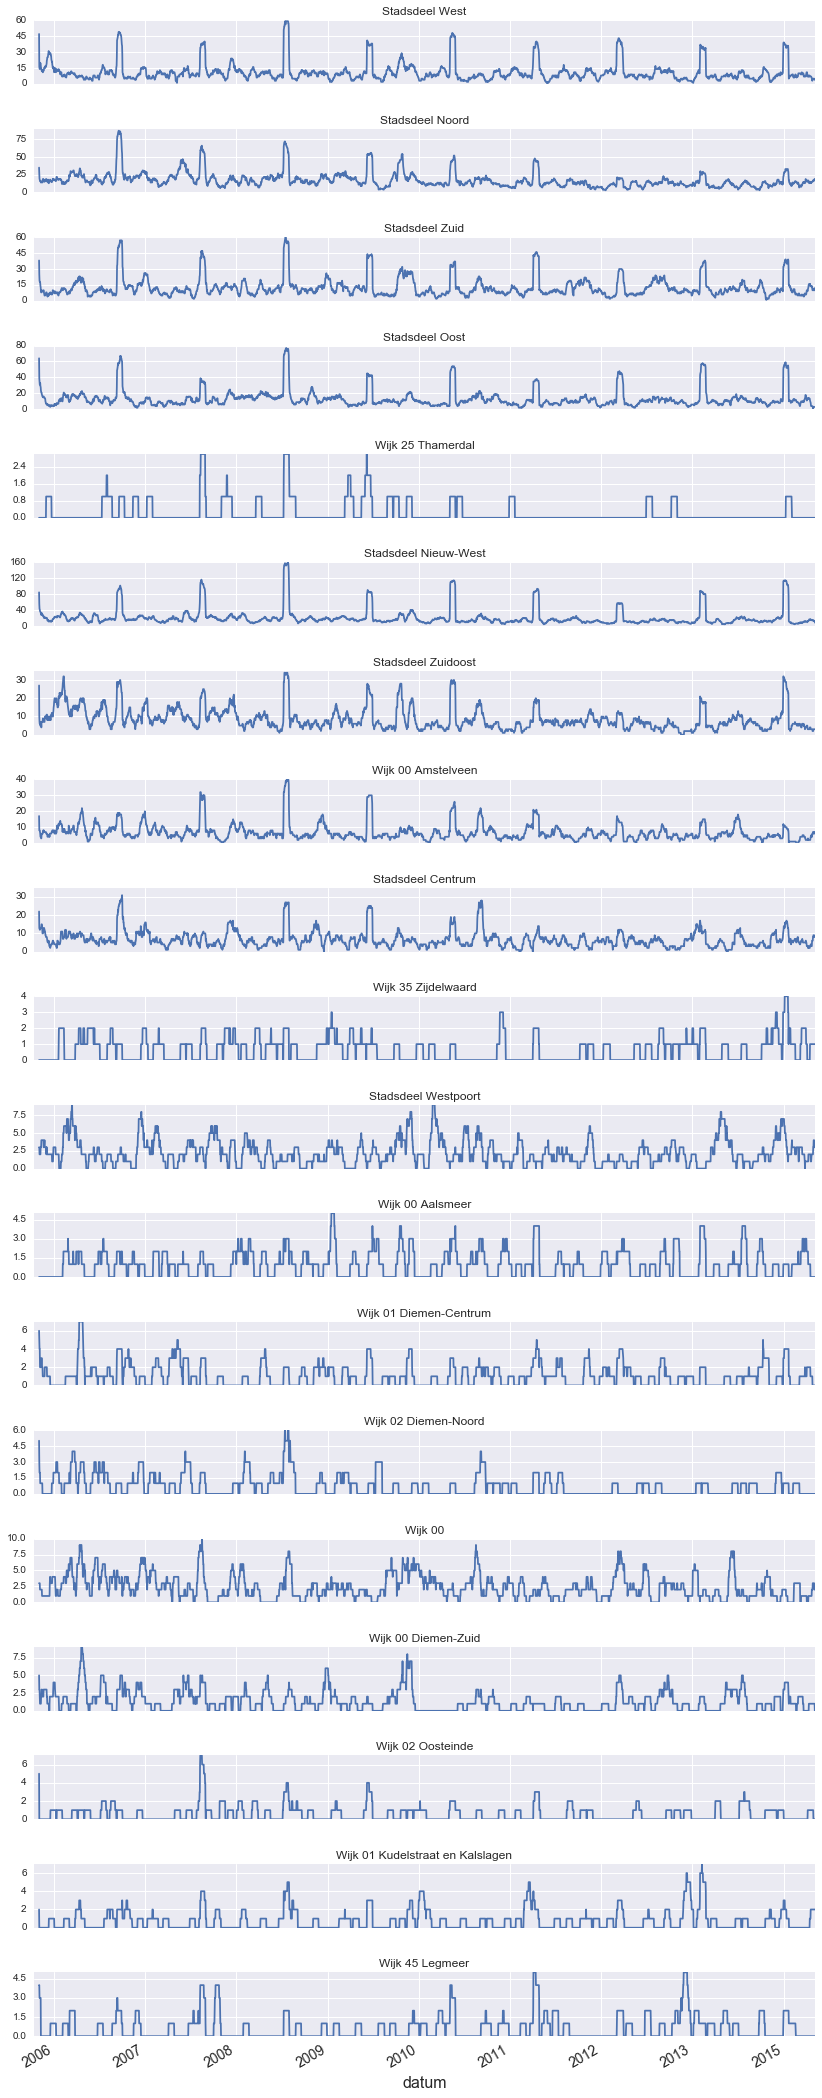

In [24]:
# plot the 'buitenbranden' per wijk over time by looping through. Clear splikes can be seen in the data.
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
fig, ax = plt.subplots(len(by_date.columns), 1, figsize=(14, 40), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0.7)

for i, col in enumerate(l3):
    by_date[col].rolling(24).sum().plot(ax=ax[i], title=col)
    ax[i].xaxis.set_ticks(np.arange(2006, 2015, 10))
    ax[i].xaxis.set_major_locator(MaxNLocator(nbins = 10))
    ax[i].yaxis.set_major_locator(MaxNLocator(nbins=4))

## Some more explorations

Because there are multiple ways to look at the data let's define a function where we can dynamically trow in a year and a variable to count on to display in horizontal barchart. Now we can quikcly see rankings of different types and year.

In [25]:
def flex_barchart(df, jaar, group_field, length, width):
    df_year = df[df.jaar == jaar]
    grouped = (df_year.groupby(group_field, as_index=False)
                      .size()
                      .reset_index()
                      .rename(columns={0: 'count'})
                      .sort_values('count', ascending=False))
    
    fig, ax = plt.subplots(figsize=(width,length))
    sns.barplot(x="count", y=group_field, data=grouped)

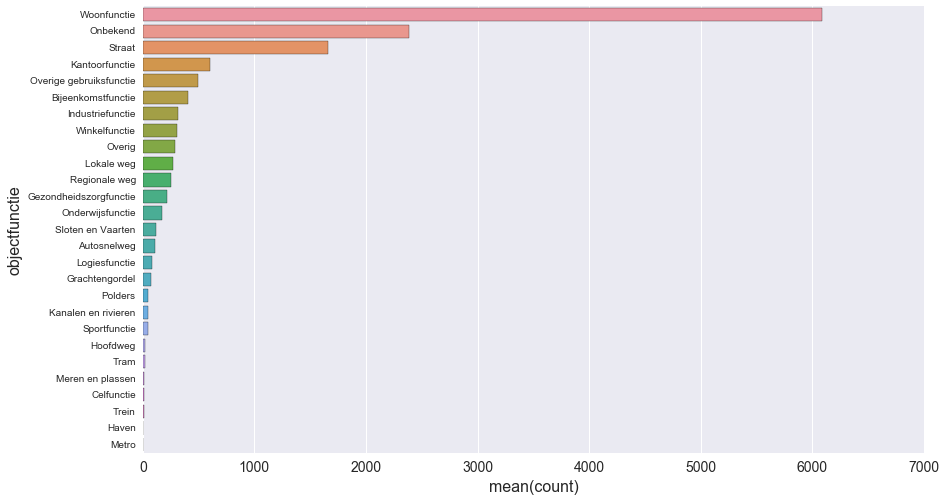

In [26]:
# so play around here: you can choose incident_type, melding_1, melding_2, melding_3 etc..
flex_barchart(df, 2006 , 'objectfunctie', 8, 14)

### Flexible heatmap

Let's make a heatmap a bit more flexible by throwing it into a function as well so we can play around with it using different variables.

In [27]:
def pivot_heatmap(df, jaar, rows, columns, values, width, length):
    df_year = df[df.jaar == jaar]
    df_pivot = df_year.pivot_table(values=values, index=rows, columns=columns, 
                                   aggfunc=np.size).dropna(axis=0, how='all')
    
    fig, ax = plt.subplots(figsize=(width,length))
    sns.heatmap(df_pivot, annot=False, fmt='g')

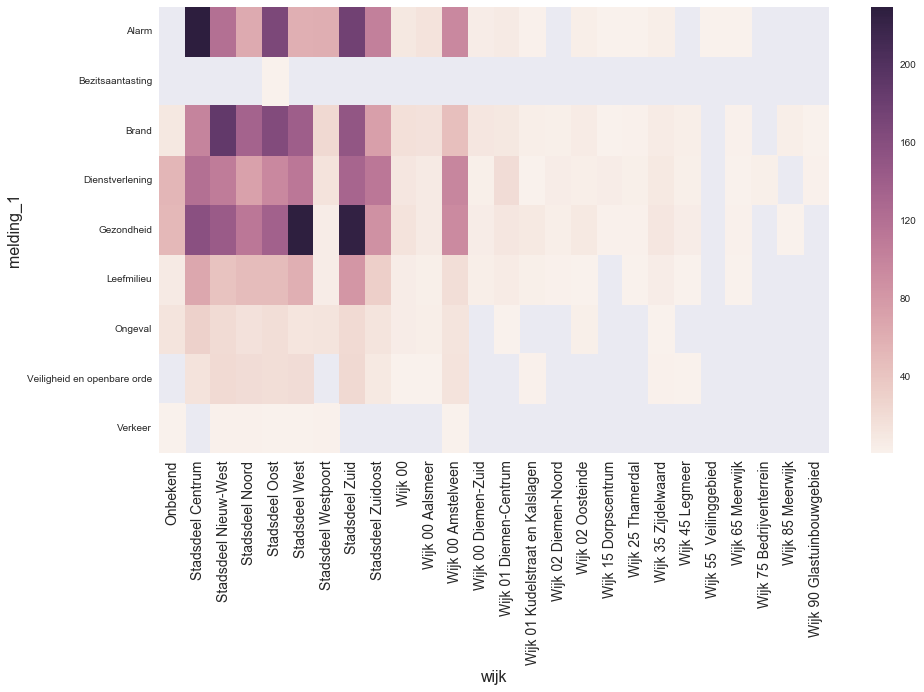

In [15]:
pivot_heatmap(df, 2015, 'melding_1','wijk','index', 15, 8)

### Look at hourly patterns

In [28]:
# create pivot table with hourly patterns for plotting purposes
df['weekend'] = np.where(df.dag_naam.isin(['Zaterdag' ,'Zondag']), 'weekend', 'weekdag')
hourly = (df.query("incident_type == 'Buitenbrand' | incident_type == 'OMS / automatische melding' \
                   | incident_type == 'Liftopsluiting'")
            .pivot_table('index', aggfunc='count', index=['weekend','uur'], columns=['incident_type']))

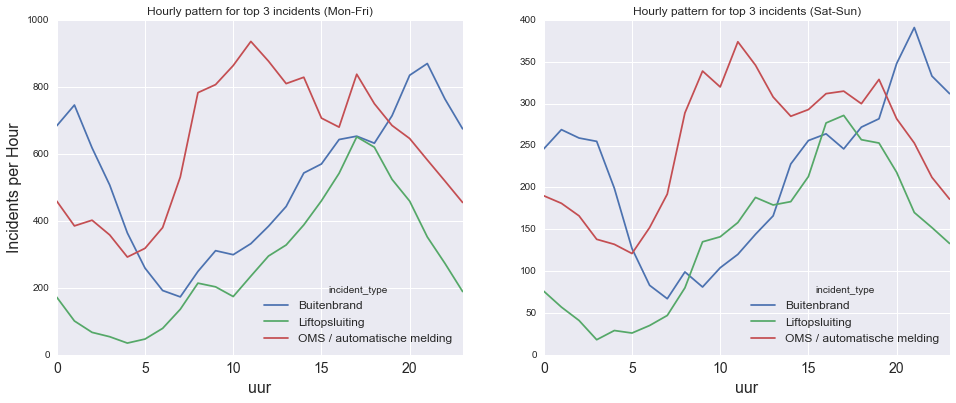

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
hourly.loc['weekdag'].plot(title='Hourly pattern for top 3 incidents (Mon-Fri)', ax=ax[0])
hourly.loc['weekend'].plot(title='Hourly pattern for top 3 incidents (Sat-Sun)', ax=ax[1])
ax[0].set_ylabel('Incidents per Hour');

OMS/automatische meldingen spike at 11h in both weekdays and weekends. Actually we see similar hourly patterns for the top 3incidents for weekdays and weekends in general. Quit surprising considering the out-going scene in the weekends. Buitenbranden (fires) don't occur much in the very early monring hours but gradually mount until the spike at +/- 21/22h.

### Create dynamic plotting line plotting

In [30]:
def multi_line(df, x, y):
    ax = df.groupby([x, y]).size().unstack(y).plot(figsize=(15,8), cmap="Set2")

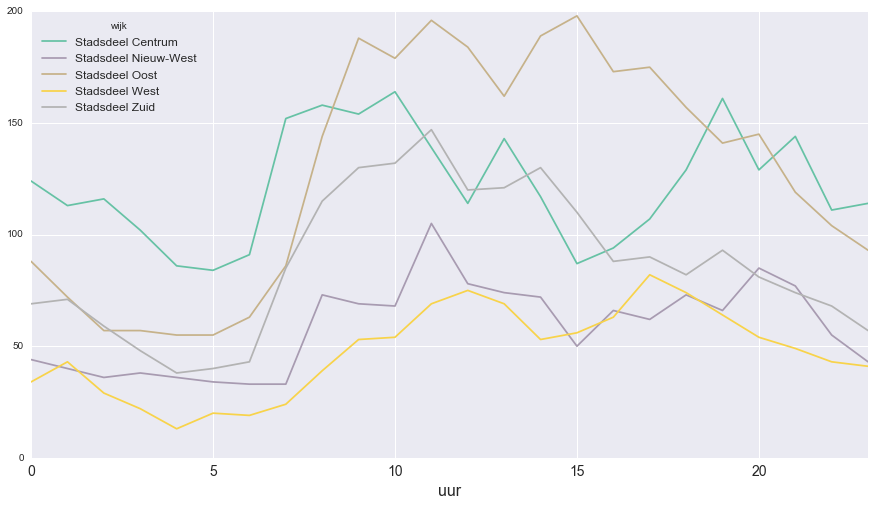

In [31]:
# plot the number of incidents per hour for the top x neigborhoods
multi_line(df.loc[df['incident_type'].isin(df['incident_type'].value_counts().index[:1])]\
             .loc[df['wijk'].isin(df['wijk'].value_counts().index[:5])], 'uur', 'wijk')

hourly patterns can differ significantly per wijk

In [32]:
## Soem more custom plotting code
def plot_incidents_by_time(data, unit='hour', wijk =None, panel=None, agg_func='count'):
    ''' Custom plotting functions that displays the number of
    incidents of each type as a function of a unit of time and
    (optionally) any categorical variable.
    '''
    if wijk is not None:
        data = data[data['wijk'].isin(wijk)]
    if panel is not None:
        if panel == 'year':
            panel_vars = [ 2011, 2012, 2013, 2014, 2015]
        else:
            panel_vars = data[panel].unique()
        n_panels = len(panel_vars)
        fig, axes = plt.subplots(1, 5, figsize=(4*n_panels, 20), sharex=True, sharey=True)
    else:
        axes = [plt.gca()]

    incidents = ['OMS / automatische melding', 'Buitenbrand', 'Liftopsluiting', 'Buitensluiting']
    dummies = pd.get_dummies(data['incident_type'])
    data = pd.concat([data, dummies], axis=1)
    
    
    for oc in incidents:
        groupers = [unit]
        if panel is not None:
            groupers.append(panel)
        line = data.query('incident_type==@oc')\
            .groupby(groupers)[oc].agg(agg_func).reset_index()
        if panel is not None:
            for i, pan in enumerate(panel_vars):
                pan_line = line[line[panel]==pan]
                axes[i].plot(pan_line[unit], pan_line[oc], label=oc, lw=3)
                axes[i].set_title('{}: {}'.format(panel, pan), fontsize=12)
                axes[i].set_xlabel(unit, fontsize=15)
                #axes[i].set_ylabel("No. of incidents", fontsize=15)
    plt.legend(fontsize=8, loc='upper left')

IndexError: index 5 is out of bounds for axis 0 with size 5

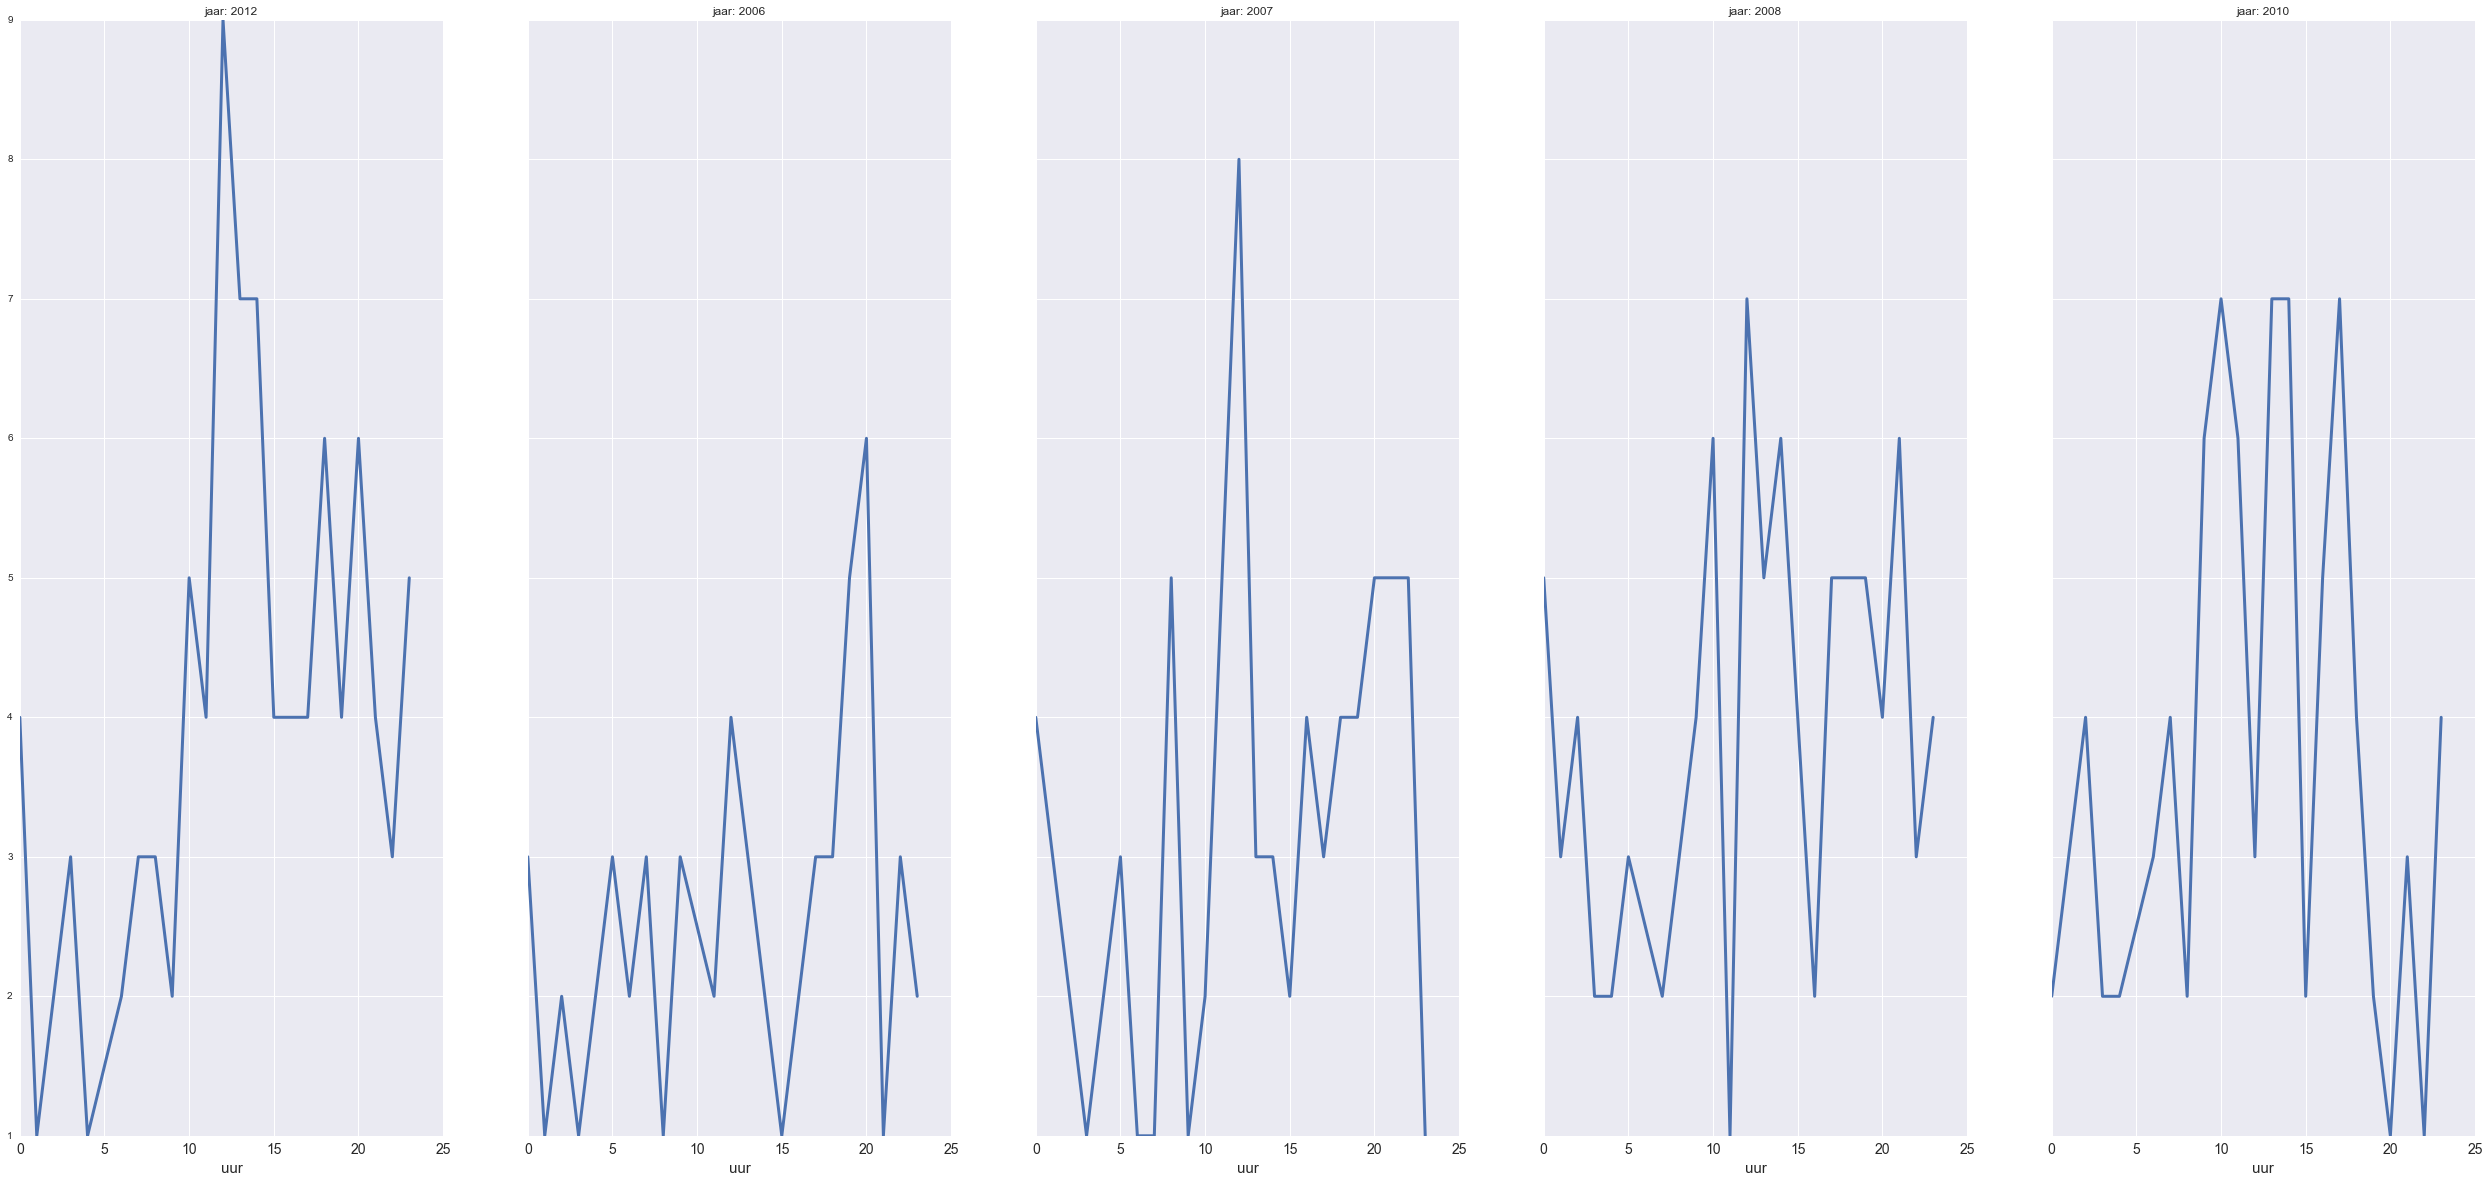

In [98]:
# uur, week_nr, maand_nr
plot_incidents_by_time(df, wijk=['Stadsdeel Noord'], unit='uur', panel='jaar')
#plt.gcf().set_size_inches((7, 5))

In [4]:
import os

In [5]:
os.getcwd()

'C:\\Users\\Schiphol\\Documents'

In [6]:
# polygons with holes are not supported. library only for basic polygon support.
wijk = shapefile.Reader('C:\\Users\\Schiphol\\Documents\\data\\esri_poly\\uitvoer_shape\\wijk_2014.shp')

In [7]:
# list of the shapefile’s geometry 
# https://github.com/GeospatialPython/pyshp/blob/master/shapefile.py
shapes = wijk.shapes()

In [67]:
# attributes of each shape record
for name in dir(shapes[3]):
    if not name.startswith('__'):
        print (name)

bbox
parts
points
shapeType


In [69]:
# for instance the bounding box of the 4th shape: tuple describing lower-left (x,y) coord and upper-right
# coord creating a complete box arounf the points
['%.3f' % coord for coord in shapes[4].bbox]

['264124.695', '564634.124', '271067.313', '574863.949']

In [72]:
# points attribute: list of tuples containing (x,y) coords for each point in the shape
['%.3f' % coord for coord in shapes[3].points[7]] #8th point of 4th shape

['275593.094', '569817.125']

A record in a shapefile contains the attributes for each shape in the collection of geometry. Records are stored in the dbf file. The link between geometry and attributes is the foundation of all geographic information systems. This critical link is implied by the order of shapes and corresponding records in the shp geometry file and the dbf attribute file.

call the “fields” attribute of the shapefile as a Python list. Every wijk has a ton of undelying info
just watch the rich underlying layers: 
- field name
- field type (C - Charachter, N -Number, L = Longs, D - Dates, M - Memo)
- fields length (length of the data)
- decimal length -  number of decimal places

In [79]:
wijk.fields[:10]

[('DeletionFlag', 'C', 1, 0),
 ['WK_CODE', 'C', 8, 0],
 ['WK_NAAM', 'C', 60, 0],
 ['GM_CODE', 'C', 6, 0],
 ['GM_NAAM', 'C', 60, 0],
 ['IND_WBI', 'N', 10, 0],
 ['WATER', 'C', 4, 0],
 ['OAD', 'N', 10, 0],
 ['STED', 'N', 10, 0],
 ['AANT_INW', 'N', 10, 0]]

Each record is a list containing an attribute corresponding to each field in the field list.

In [77]:
# length of the recors of the wijk dfb recors 
len(list(wijk.iterRecords()))

2836

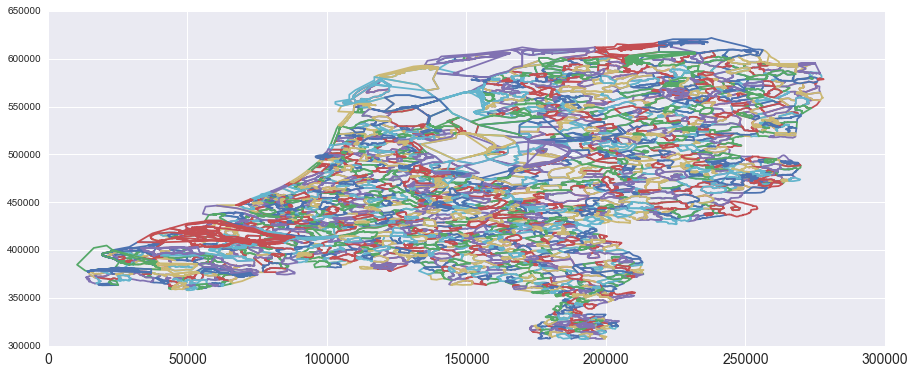

In [93]:
# http://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
plt.figure()
for shape in wijk.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

unreadible and to much info. Decartes module to plot polygons from shapefiles using polygonPatches objects. 
http://geographika.co.uk/visualising-geojson-in-15-minutes

In [8]:
# A shapefile has the geo_interface convention, you can use it. Python __geo_interface__ 
wijk.shape(0).__geo_interface__["type"]

'Polygon'

In [103]:
wijk.iterShapes

<bound method Reader.iterShapes of <shapefile.Reader object at 0x00000000605FCD30>>

In [9]:
def read_shapefile(filepath):
    """
    Read shapefile at filepath with the pyshp library
    returns tuples: (polygons, bbox, attributes)
    """
    reader = shapefile.Reader(filepath)
    
    # first field, called "DeletionFlag", seems to be just trash (thus the [1:])
    field_names = [field_name for field_name, _, _, _ in reader.fields[1:]]
   
    for record, shape in zip(reader.iterRecords(), reader.iterShapes()):
        # All of the shapes in the wijk2014 dataset have shape.shapeType == 5 (polygon)
        attributes = dict(zip(field_names, record))
        
        # shape.parts` denotes indices of beginning/ ending of each polygon in this shape
        # though often country is just one even with multiple polygons, though, the shape's 
        # points are just a long list, and the shape.parts used to differentiate between 
        # the polygons within that list
        parts = shape.parts.tolist() + [len(shape.points)]
        polygons = [shape.points[i:j] for i, j in zip(parts, parts[1:])]
  
    return polygons, shape.bbox, attributes # yield for generator object

In [10]:
test = read_shapefile('C:\\Users\\Schiphol\\Documents\\data\\esri_poly\\uitvoer_shape\\wijk_2014.shp')

In [11]:
test

([[(123593.58002850041, 380115.25003569946),
   (123625.71002849936, 379758.020035699),
   (123632.39702850208, 379677.01503570005),
   (123632.59002850205, 379674.68003569916),
   (123629.78002849966, 379674.57003569975),
   (123627.21102850139, 379674.4650356993),
   (123457.08002850041, 379667.53003570065),
   (123396.72502849996, 379665.14903569967),
   (123347.85002849996, 379663.220035702),
   (123343.48402849957, 379663.0490357019),
   (123337.89602850005, 379662.8300357014),
   (123086.30302850157, 379652.89903569967),
   (123082.77002850175, 379652.7600357011),
   (123089.52302850038, 379657.84903570265),
   (123089.7900285013, 379658.0500357002),
   (123090.64602850005, 379658.66303570196),
   (123098.27002850175, 379664.13003570214),
   (123107.9000285007, 379673.25003569946),
   (123115.7900285013, 379682.89003570005),
   (123118.06002850085, 379684.1100357026),
   (123168.80002849922, 379681.4000357017),
   (123172.81002850085, 379682.3400356993),
   (123186.10002849996, 3

In [142]:
from descartes import PolygonPatch  

http://nullege.com/codes/show/src%40f%40s%40fsdf-hackfest-HEAD%40examples%40python-basemap%40demo_shapefile.py/52/shapefile.Reader/python

https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/